In [4]:
# IMPORTS

from torchvision.datasets import ImageFolder
from torchvision import transforms
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from skl2onnx import to_onnx
from torch import nn
import torch, onnx, io, dill
import numpy as np
import onnxruntime as ort

In [16]:
# CONFIGURATION

INPUT_SHAPE = (128, 128)
NUM_CHANNELS = 3
TEST_SIZE = 0.15
SEED = 42
SESSION_NAME = '2_SVM'
MODEL_NAME = 'svm'

In [6]:
# DATA PREPARATION

flatten = nn.Flatten()

transform = transforms.Compose([
    transforms.Resize(INPUT_SHAPE),
    transforms.ToTensor(),
])

dataset = ImageFolder('data/raw', transform=transform)

In [7]:
# DATA SPLIT

ds_idx = list(range(len(dataset)))
train_idx, test_idx = train_test_split(ds_idx, test_size=TEST_SIZE, shuffle=True, stratify=dataset.targets, random_state=SEED)

In [8]:
# LOAD DATA

X_train = torch.stack([dataset[i][0] for i in train_idx])
y_train = [dataset[i][1] for i in train_idx]

X_test = torch.stack([dataset[i][0] for i in test_idx])
y_test = [dataset[i][1] for i in test_idx]

X_train_flat = flatten(X_train)
X_test_flat = flatten(X_test)

In [9]:
# PREPARE MODEL

svc = SVC(probability=True)

In [10]:
# HYPERPARAMETER TUNING

param_dist = {
    'C': np.logspace(-3, 3, 7),
    'gamma': np.logspace(-3, 3, 7)
}

rscv = RandomizedSearchCV(svc, param_dist, cv=10, n_jobs=-1, random_state=SEED, scoring='accuracy', verbose=3)

In [11]:
# TRAINING

rscv.fit(X_train_flat, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 2/10] END .............C=0.01, gamma=1000.0;, score=0.293 total time=24.9min
[CV 3/10] END .............C=0.01, gamma=1000.0;, score=0.295 total time=25.4min
[CV 1/10] END .............C=0.01, gamma=1000.0;, score=0.301 total time=25.7min
[CV 7/10] END .............C=0.01, gamma=1000.0;, score=0.303 total time=25.7min
[CV 6/10] END .............C=0.01, gamma=1000.0;, score=0.295 total time=27.4min
[CV 5/10] END .............C=0.01, gamma=1000.0;, score=0.295 total time=27.5min
[CV 4/10] END .............C=0.01, gamma=1000.0;, score=0.295 total time=27.6min
[CV 8/10] END .............C=0.01, gamma=1000.0;, score=0.303 total time=27.4min
[CV 9/10] END .............C=0.01, gamma=1000.0;, score=0.303 total time=25.6min
[CV 1/10] END ..............C=1000.0, gamma=1.0;, score=0.301 total time=26.6min
[CV 10/10] END ............C=0.01, gamma=1000.0;, score=0.303 total time=27.3min
[CV 2/10] END ..............C=1000.0, gamma=1.

RandomizedSearchCV(cv=10, estimator=SVC(probability=True), n_jobs=-1,
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
                   random_state=42, scoring='accuracy', verbose=3)

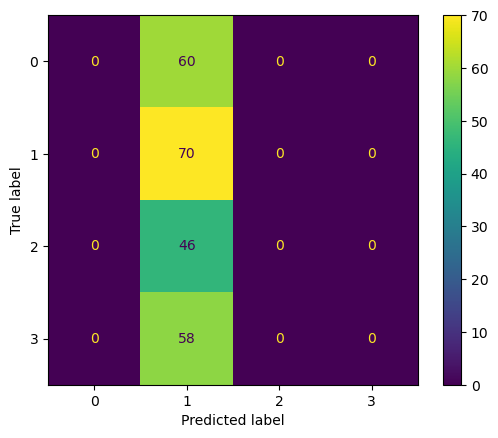

In [12]:
# CONFUSION MATRIX

ConfusionMatrixDisplay.from_estimator(rscv.best_estimator_, X_test_flat, y_test)

In [13]:
# CLASSIFICATION REPORT

y_pred = rscv.best_estimator_.predict(X_test_flat)
report = classification_report(y_test, y_pred, target_names=dataset.classes)
print(report)

              precision    recall  f1-score   support

          AK       0.00      0.00      0.00        60
   KAPADOKYA       0.30      1.00      0.46        70
       NURLU       0.00      0.00      0.00        46
        SIRA       0.00      0.00      0.00        58

    accuracy                           0.30       234
   macro avg       0.07      0.25      0.12       234
weighted avg       0.09      0.30      0.14       234



/opt/homebrew/Caskroom/miniconda/base/envs/vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [14]:
# CONVERT TO ONNX

classifier = to_onnx(rscv.best_estimator_, np.array(X_test[:1]).astype(np.float32), options={"zipmap": False})

preprocessor = io.BytesIO()
torch.onnx.export(
    flatten, 
    torch.rand(1, 3, INPUT_SHAPE[0], INPUT_SHAPE[1]), 
    preprocessor, input_names=['input'], output_names=['output'],
    dynamic_axes={'input': {0: '?'}}
)
preprocessor = onnx.load_model_from_string(preprocessor.getvalue())

graph = onnx.compose.merge_graphs(preprocessor.graph, classifier.graph, io_map=[('output', 'X')])
model = onnx.helper.make_model(graph)

In [17]:
# SAVE MODEL

with open(f'models/{MODEL_NAME}.onnx', 'wb') as f:
    f.write(model.SerializeToString())

In [18]:
# SANITY CHECK

sess = ort.InferenceSession(f'models/{MODEL_NAME}.onnx')
output = sess.run(['label', 'probabilities'], {'input': X_test.numpy()})

if (output[0] == y_pred).all():
    print('SUCCESS')
else:
    print('FAILURE')

SUCCESS


In [22]:
# SAVE NOTEBOOK SESSION

dill.dump_session(f'sessions/{SESSION_NAME}.dill')

In [ ]:
# # LOAD NOTEBOOK SESSION

# import dill
# dill.load_session('sessions/{SESSION_NAME}.dill')